In [1]:
%pip install pandas
%pip install numpy
%pip install torch
%pip install scikit-learn
%pip install matplotlib
%pip install tqdm
%pip install google
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Hyperparameters
NUM_CLASSES = 2  # Binary classification (0: no signal peptide, 1: signal peptide)
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001
MAX_LENGTH = 100  # maybe adjust
WINDOW_SIZE = 35  # sliding window (odd because model predicts center residue)
STRIDE = 1  # Step size

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Using device: mps
Using device: mps


In [2]:
# Paths for local execution
import os
DATA_PATH = "/Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe1/"
TRAIN_CSV = os.path.join(DATA_PATH, "reduced_30_signalP6_train.csv")
VAL_CSV = os.path.join(DATA_PATH, "reduced_30_signalP6_val.csv")
TEST_CSV = os.path.join(DATA_PATH, "reduced_30_signalP6_test.csv")
MODEL_PATH = "/Users/jonas/Desktop/Uni/PBL/sp-prediction/models/2state_ohe_lin_v1.pt"

# Create models directory if it doesn't exist
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)


In [3]:
aas = 'ARNDCEQGHILKMFPSTWYV'
aa2idx = {aa: i for i, aa in enumerate(aas)}
idx2aa = {i: aa for aa, i in aa2idx.items()}
num_aa = len(aas)

def one_hot_encode_window(seq_window):
    """One-hot encode a sequence window"""
    encoding = np.zeros((len(seq_window), num_aa))

    for i, aa in enumerate(seq_window):
        if aa in aa2idx:
            encoding[i, aa2idx[aa]] = 1
        # Unknown amino acids remain as zero vectors (as is the default)
    return encoding

In [4]:
def create_sliding_windows(sequence, labels, window_size, stride=1):
    """Create sliding windows from sequence and corresponding labels"""
    windows = []
    window_labels = []
    positions = []

    # Pad sequence for edge cases
    pad_size = window_size // 2 # so starts classification after padding, at first real encoding
    padded_seq = 'X' * pad_size + sequence + 'X' * pad_size
    padded_labels = [0] * pad_size + labels + [0] * pad_size

    # Create sliding windows
    for i in range(0, len(sequence), stride):
        start_idx = i
        end_idx = i + window_size

        if end_idx <= len(padded_seq):
            window_seq = padded_seq[start_idx:end_idx]
            # Label for the center position of the window
            center_idx = start_idx + pad_size # residue to predict
            if center_idx < len(padded_labels):
                center_label = padded_labels[center_idx]

                windows.append(window_seq)
                window_labels.append(center_label)
                positions.append(i)  # Original position in sequence

    return windows, window_labels, positions

In [5]:
def load_and_preprocess_data(csv_path):
    """Load CSV data and preprocess for sliding window approach"""
    # Load CSV file
    df = pd.read_csv(csv_path)
    
    print(f"Total records loaded: {len(df)}")
    
    # Filter out sequences with 'P' in labels (if needed)
    df = df[~df["labels"].str.contains("P", na=False)]
    
    print(f"Records after filtering: {len(df)}")
    
    # Convert residue-level labels to binary
    label_map = {'S': 1, 'T': 1, 'L': 1, 'I': 0, 'M': 0, 'O': 0}
    
    # Create sliding windows for all sequences
    all_windows = []
    all_labels = []
    all_seq_ids = []
    
    for idx, row in df.iterrows():
        sequence = row["sequence"]
        label_string = row["labels"]
        
        # Convert label string to binary array
        residue_labels = [label_map.get(c, 0) for c in label_string]
        
        # Skip sequences where label length doesn't match sequence length
        if len(residue_labels) != len(sequence):
            print(f"Sequence length mismatch at index {idx}")
            continue
        
        # Create sliding windows for this sequence
        windows, window_labels, positions = create_sliding_windows(
            sequence, residue_labels, WINDOW_SIZE, STRIDE
        )
        
        all_windows.extend(windows)
        all_labels.extend(window_labels)
        all_seq_ids.extend([idx] * len(windows))
    
    print(f"Total windows created: {len(all_windows)}")
    print(f"Signal peptide windows: {sum(all_labels)}")
    print(f"Non-signal peptide windows: {len(all_labels) - sum(all_labels)}")
    
    return all_windows, all_labels, all_seq_ids

In [6]:
class SlidingWindowDataset(Dataset):
    def __init__(self, windows, labels, window_size):
        self.windows = windows
        self.labels = labels
        self.window_size = window_size

        # Pre-encode all windows
        self.encoded_windows = []
        for window in windows:
            encoded = one_hot_encode_window(window)
            self.encoded_windows.append(encoded)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return {
            'window': torch.tensor(self.encoded_windows[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [7]:
class SlidingWindowSignalPeptideClassifier(nn.Module):
    def __init__(self, window_size, num_aa, hidden_dim=128, num_layers=2, use_cnn=True):
        super().__init__()
        self.window_size = window_size
        self.num_aa = num_aa
        self.use_cnn = use_cnn

        if use_cnn:
            # CNN approach - better for local patterns
            self.conv_layers = nn.Sequential(
                nn.Conv1d(num_aa, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Conv1d(64, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.AdaptiveAvgPool1d(1)  # Global average pooling
            )
            fc_input_dim = 32
        else:
            # MLP approach - flatten the window
            fc_input_dim = window_size * num_aa

        # Final classification layers
        layers = []
        in_dim = fc_input_dim

        for _ in range(num_layers):
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            in_dim = hidden_dim

        # Binary classification output
        layers.append(nn.Linear(hidden_dim, 1))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        # x: [batch_size, window_size, num_aa]
        batch_size = x.size(0)

        if self.use_cnn:
            # Transpose for Conv1d: [batch_size, num_aa, window_size]
            x = x.transpose(1, 2)
            x = self.conv_layers(x)
            x = x.view(batch_size, -1)  # Flatten
        else:
            # Flatten for MLP
            x = x.view(batch_size, -1)

        logits = self.classifier(x)
        return logits.squeeze(-1)  # Remove last dimension for binary classification

In [8]:
def train_model(model, train_loader, val_loader, num_epochs, device):
    """Train the sliding window model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            windows = batch['window'].to(device)
            labels = batch['label'].to(device).float()

            optimizer.zero_grad()

            logits = model(windows)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                windows = batch['window'].to(device)
                labels = batch['label'].to(device).float()

                logits = model(windows)
                loss = criterion(logits, labels)

                val_loss += loss.item()
                val_batches += 1

                # Calculate accuracy
                predictions = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_batches
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), MODEL_PATH)

    return train_losses, val_losses

In [9]:
# compute percentage of false predicted labels
def sequence_level_accuracy(predictions, labels):
    correct = 0
    total = 0
    for pred, label in zip(predictions, labels):
        if len(pred) != len(label):
            min_len = min(len(pred), len(label))
            pred = pred[:min_len]
            label = label[:min_len]
        total += 1
        if (pred == label).all():
            correct += 1
    return correct / total

In [10]:
def evaluate_model(model, test_loader, device):
    """Evaluate the sliding window model"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            windows = batch['window'].to(device)
            labels = batch['label'].to(device)

            logits = model(windows)
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities > 0.5).long()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['No Signal', 'Signal']))

    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    mcc = matthews_corrcoef(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"F1 Score (weighted): {f1_weighted:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    return all_preds, all_labels, all_probs

def predict_sequence(model, sequence, window_size, device, threshold=0.5):
    """Predict signal peptide positions for a full sequence"""
    model.eval()

    # Create dummy labels (we don't need them for prediction)
    dummy_labels = [0] * len(sequence)

    # Create sliding windows
    windows, _, positions = create_sliding_windows(sequence, dummy_labels, window_size, stride=1)

    # Encode windows
    encoded_windows = [one_hot_encode_window(window) for window in windows]

    predictions = []
    probabilities = []

    with torch.no_grad():
        for encoded_window in encoded_windows:
            window_tensor = torch.tensor(encoded_window, dtype=torch.float32).unsqueeze(0).to(device)
            logit = model(window_tensor)
            prob = torch.sigmoid(logit).item()
            pred = int(prob > threshold)

            predictions.append(pred)
            probabilities.append(prob)

    return predictions, probabilities, positions

Loading training data...
Total records loaded: 10940
Records after filtering: 10925
Total windows created: 764750
Signal peptide windows: 44573
Non-signal peptide windows: 720177

Loading validation data...
Total records loaded: 2735
Records after filtering: 2725
Total windows created: 190750
Signal peptide windows: 11064
Non-signal peptide windows: 179686

Loading test data...
Total records loaded: 3419
Records after filtering: 3410
Total windows created: 238700
Signal peptide windows: 13786
Non-signal peptide windows: 224914

Train windows: 764750
Validation windows: 190750
Test windows: 238700
Total windows created: 764750
Signal peptide windows: 44573
Non-signal peptide windows: 720177

Loading validation data...
Total records loaded: 2735
Records after filtering: 2725
Total windows created: 190750
Signal peptide windows: 11064
Non-signal peptide windows: 179686

Loading test data...
Total records loaded: 3419
Records after filtering: 3410
Total windows created: 238700
Signal pepti

Epoch 1/10: 100%|██████████| 23899/23899 [02:13<00:00, 179.38it/s, loss=0.0101]



Epoch 1/10 - Train Loss: 0.0821, Val Loss: 0.0643, Val Acc: 0.9770


Epoch 2/10: 100%|██████████| 23899/23899 [02:11<00:00, 181.86it/s, loss=0.2317]


Epoch 2/10 - Train Loss: 0.0667, Val Loss: 0.0611, Val Acc: 0.9781


Epoch 3/10: 100%|██████████| 23899/23899 [02:11<00:00, 181.57it/s, loss=0.0025]


Epoch 3/10 - Train Loss: 0.0633, Val Loss: 0.0593, Val Acc: 0.9787


Epoch 4/10: 100%|██████████| 23899/23899 [02:08<00:00, 186.09it/s, loss=0.0257]


Epoch 4/10 - Train Loss: 0.0613, Val Loss: 0.0590, Val Acc: 0.9792


Epoch 5/10: 100%|██████████| 23899/23899 [02:06<00:00, 188.84it/s, loss=0.0104]


Epoch 5/10 - Train Loss: 0.0602, Val Loss: 0.0594, Val Acc: 0.9787


Epoch 6/10: 100%|██████████| 23899/23899 [02:12<00:00, 180.38it/s, loss=0.0524]


Epoch 6/10 - Train Loss: 0.0595, Val Loss: 0.0576, Val Acc: 0.9795


Epoch 7/10: 100%|██████████| 23899/23899 [02:13<00:00, 178.78it/s, loss=0.0037]


Epoch 7/10 - Train Loss: 0.0590, Val Loss: 0.0577, Val Acc: 0.9795


Epoch 8/10: 100%|██████████| 23899/23899 [02:13<00:00, 178.95it/s, loss=0.0060]


Epoch 8/10 - Train Loss: 0.0584, Val Loss: 0.0580, Val Acc: 0.9796


Epoch 9/10: 100%|██████████| 23899/23899 [02:13<00:00, 178.44it/s, loss=0.0123]


Epoch 9/10 - Train Loss: 0.0582, Val Loss: 0.0588, Val Acc: 0.9796


Epoch 10/10: 100%|██████████| 23899/23899 [02:14<00:00, 177.74it/s, loss=0.0245]


Epoch 10/10 - Train Loss: 0.0578, Val Loss: 0.0579, Val Acc: 0.9796

Final Evaluation:


Evaluating: 100%|██████████| 7460/7460 [00:10<00:00, 710.75it/s]



Classification Report:
              precision    recall  f1-score   support

   No Signal       0.99      0.99      0.99    224914
      Signal       0.87      0.76      0.81     13786

    accuracy                           0.98    238700
   macro avg       0.93      0.88      0.90    238700
weighted avg       0.98      0.98      0.98    238700

F1 Score (weighted): 0.9791
F1 Score (macro): 0.9008
Matthews Correlation Coefficient: 0.8038
Accuracy: 0.9797
F1 Score (weighted): 0.9791
F1 Score (macro): 0.9008
Matthews Correlation Coefficient: 0.8038
Accuracy: 0.9797


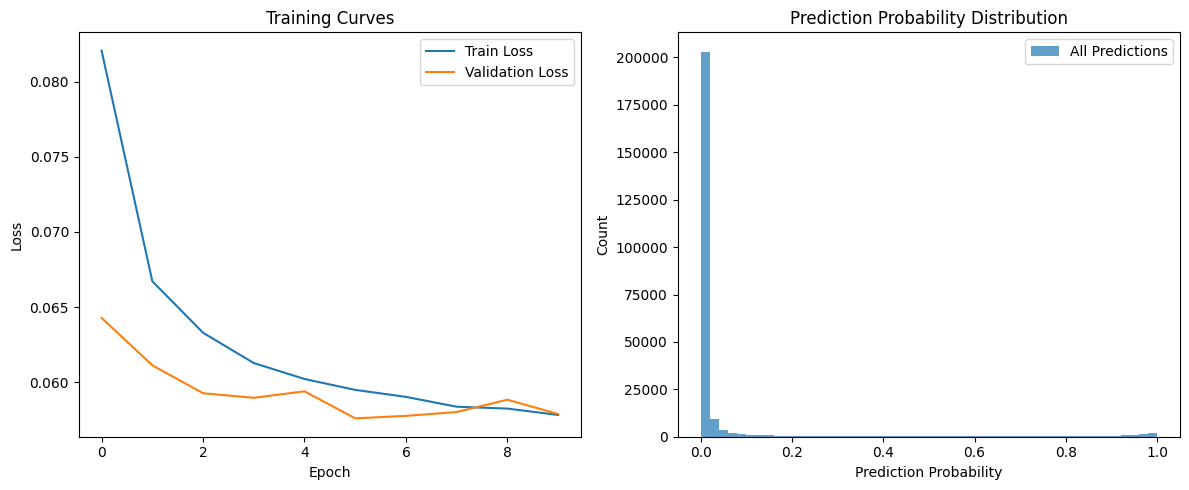

In [11]:
# Load and preprocess data with sliding windows from separate CSV files
print("Loading training data...")
train_windows, train_labels, train_seq_ids = load_and_preprocess_data(TRAIN_CSV)

print("\nLoading validation data...")
val_windows, val_labels, val_seq_ids = load_and_preprocess_data(VAL_CSV)

print("\nLoading test data...")
test_windows, test_labels, test_seq_ids = load_and_preprocess_data(TEST_CSV)

print(f"\nTrain windows: {len(train_windows)}")
print(f"Validation windows: {len(val_windows)}")
print(f"Test windows: {len(test_windows)}")

# Create datasets and loaders
train_dataset = SlidingWindowDataset(train_windows, train_labels, WINDOW_SIZE)
val_dataset = SlidingWindowDataset(val_windows, val_labels, WINDOW_SIZE)
test_dataset = SlidingWindowDataset(test_windows, test_labels, WINDOW_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model (CNN version)
model = SlidingWindowSignalPeptideClassifier(
    WINDOW_SIZE, num_aa, hidden_dim=128, num_layers=2, use_cnn=False
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader, EPOCHS, DEVICE)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# Evaluate model
print("\nFinal Evaluation:")
predictions, labels_true, probabilities = evaluate_model(model, test_loader, DEVICE)

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')

plt.subplot(1, 2, 2)
plt.hist(probabilities, bins=50, alpha=0.7, label='All Predictions')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Example on sample sequence
sample_sequence = "MKKTAIAIAVALAGFATVAQAAPKDNTWYTGAKLGHLQGPVRGVNPTTNAASMKNFTNDIKKEDTSFVTLDAAQ"
print(f"\nExample prediction for sequence: {sample_sequence[:50]}...")
preds, probs, pos = predict_sequence(model, sample_sequence, WINDOW_SIZE, DEVICE)

print("Position\tAA\tProbability\tPrediction")
for i, (pred, prob, position) in enumerate(zip(preds[:20], probs[:20], pos[:20])):
    aa = sample_sequence[position] if position < len(sample_sequence) else 'X'
    print(f"{position:3d}\t{aa}\t{prob:.3f}\t\t{'Signal' if pred else 'No Signal'}")

# Save final model
torch.save(model.state_dict(), MODEL_PATH)
print(f"\nFinal model saved to {MODEL_PATH}")


Example prediction for sequence: MKKTAIAIAVALAGFATVAQAAPKDNTWYTGAKLGHLQGPVRGVNPTTNA...
Position	AA	Probability	Prediction
  0	M	0.968		Signal
  1	K	0.998		Signal
  2	K	0.988		Signal
  3	T	0.992		Signal
  4	A	0.988		Signal
  5	I	0.993		Signal
  6	A	0.994		Signal
  7	I	0.997		Signal
  8	A	0.993		Signal
  9	V	0.998		Signal
 10	A	0.994		Signal
 11	L	0.998		Signal
 12	A	0.998		Signal
 13	G	0.996		Signal
 14	F	0.989		Signal
 15	A	0.987		Signal
 16	T	0.975		Signal
 17	V	0.961		Signal
 18	A	0.952		Signal
 19	Q	0.907		Signal

Final model saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/2state_ohe_lin_v1.pt
Position	AA	Probability	Prediction
  0	M	0.968		Signal
  1	K	0.998		Signal
  2	K	0.988		Signal
  3	T	0.992		Signal
  4	A	0.988		Signal
  5	I	0.993		Signal
  6	A	0.994		Signal
  7	I	0.997		Signal
  8	A	0.993		Signal
  9	V	0.998		Signal
 10	A	0.994		Signal
 11	L	0.998		Signal
 12	A	0.998		Signal
 13	G	0.996		Signal
 14	F	0.989		Signal
 15	A	0.987		Signal
 16	T	0.975		Signal
 17	V	0.9